# **LearningRate fijo (RMSprop)**

## **Importar dataset**

In [ ]:
import kagglehub    # Libreria para la descarga de archivos de kaggle

# Download latest version
path = kagglehub.dataset_download("gpiosenka/railway-track-fault-detection-resized-224-x-224")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/railway-track-fault-detection-resized-224-x-224


## **Directorios**

In [ ]:
# Necesitaremos la librería os, que nos permite interactuar con el sistema operativo y manipular rutas.
import os

# Directorio de entrenamiento:
train_dir = os.path.join(path, 'train')
# Directorio de pruebas:
test_dir = os.path.join(path, 'test')
# Directorio de validacion:
valid_dir = os.path.join(path, 'valid')

## **Importar modelos**

In [ ]:
# Los modelos pre-entrenados se encontrarán en la librería de tensorflow.
import tensorflow as tf

# Aprovechamos para fijar la semilla y evitar la aleatoriedad entre simulaciones.
import random
import numpy as np

# Fijar semillas
Semilla = 42
os.environ['PYTHONHASHSEED'] = str(Semilla) # Controlamos la aleatoridad en el hashing de objetos.
random.seed(Semilla)                        # Controlamos la aleatoridad en la generación de números aleatorios.
np.random.seed(Semilla)                     # Controlamos la aleatoridad en la generación de números aleatorios en numpy.
tf.random.set_seed(Semilla)                 # Controlamos la aleatoridad en la generación de números aleatorios en tensorflow.

# Configurar comportamiento determinista en TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'    # Configuramos una variable de entorno destinada a ciertas operaciones no deterministas como deterministas.

### VGG16

In [ ]:
def modelo_base ():
  VGG16_Base = (tf.keras.applications.VGG16(include_top=False,        # Eliminamos su clasificador.
                                          weights='imagenet',         # Mantenemos los pesos de cada capa.
                                          input_shape=(224, 224, 3))) # Especificamos el tamaño de los datos de entrada.
  # Congelamos el modelo.
  for layer in VGG16_Base.layers:
    layer.trainable = False
  return VGG16_Base

## **Entrenamiento**

### Datos de entrada

In [ ]:
# Importamos la clase ImageDataGenerator contenido en Keras.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

# Definimos los generadores para cada uno de los conjuntos.
train_data = datagen.flow_from_directory(
    train_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    subset='training'          # Nombre del subset originado.
)
validation_data = datagen.flow_from_directory(
    valid_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)
test_data = datagen.flow_from_directory(
    test_dir,                  # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


### Modelo VGG16 (0.01)

In [ ]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_001.add(tf.keras.layers.Flatten())
VGG16_001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_001.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [ ]:
# Compilamos el modelo antes definido.
VGG16_001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate = 0.01),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_001_start_time = time.time()
VGG16_001_history = VGG16_001.fit(
    train_data,
    epochs=10,
    validation_data=validation_data)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - acc: 0.4990 - loss: 552.6943 - val_acc: 0.5000 - val_loss: 37.6597
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - acc: 0.5009 - loss: 18.1304 - val_acc: 0.6290 - val_loss: 1.0696
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - acc: 0.6947 - loss: 0.6726 - val_acc: 0.7903 - val_loss: 0.5116
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - acc: 0.7853 - loss: 0.4229 - val_acc: 0.5806 - val_loss: 1.7899
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - acc: 0.6712 - loss: 1.7969 - val_acc: 0.5000 - val_loss: 7.6783
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - acc: 0.5806 - loss: 6.0117 - val_acc: 0.7742 - val_loss: 0.4890
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - acc: 0.7366 - loss: 0.9272 - val_acc: 0.5000 - val_loss: 9.9828
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - acc: 0.5714 - loss: 3.5915 - val_acc: 0.5000 - val_loss: 1.4968
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step 

In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_001_acc1 = VGG16_001_history.history['acc']
VGG16_001_val_acc1 = VGG16_001_history.history['val_acc']
VGG16_001_loss1 = VGG16_001_history.history['loss']
VGG16_001_val_loss1 = VGG16_001_history.history['val_loss']

In [ ]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate = 0.01),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_001_history = VGG16_001.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_001_end_time - VGG16_001_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - acc: 0.5619 - loss: 1639.5237 - val_acc: 0.7097 - val_loss: 0.6027
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - acc: 0.5808 - loss: 2.6420 - val_acc: 0.5806 - val_loss: 0.8086
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - acc: 0.6792 - loss: 2.3109 - val_acc: 0.5000 - val_loss: 14.6543
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - acc: 0.5360 - loss: 7.5577 - val_acc: 0.7258 - val_loss: 0.5956
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - acc: 0.7045 - loss: 0.6109 - val_acc: 0.7258 - val_loss: 0.5617
Tiempo de ejecución: 53.592040061950684 segundos


In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_001_acc2 = VGG16_001_history.history['acc']
VGG16_001_val_acc2 = VGG16_001_history.history['val_acc']
VGG16_001_loss2 = VGG16_001_history.history['loss']
VGG16_001_val_loss2 = VGG16_001_history.history['val_loss']

### Modelo VGG16 (0.005)

In [ ]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_0005 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_0005.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_0005.add(tf.keras.layers.Flatten())
VGG16_0005.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_0005.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_0005.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_0005.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [ ]:
# Compilamos el modelo antes definido.
VGG16_0005.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate = 0.005),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0005_start_time = time.time()
VGG16_0005_history = VGG16_0005.fit(
    train_data,
    epochs=10,
    validation_data=validation_data)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - acc: 0.4977 - loss: 167.8979 - val_acc: 0.5000 - val_loss: 1.6654
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - acc: 0.4488 - loss: 3.2114 - val_acc: 0.5161 - val_loss: 0.7982
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - acc: 0.6595 - loss: 0.6308 - val_acc: 0.5645 - val_loss: 0.6846
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - acc: 0.5870 - loss: 1.2019 - val_acc: 0.5645 - val_loss: 0.7524
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - acc: 0.6448 - loss: 0.6201 - val_acc: 0.8226 - val_loss: 0.5110
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - acc: 0.7418 - loss: 0.6219 - val_acc: 0.5323 - val_loss: 1.6355
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - acc: 0.5419 - loss: 1.2305 - val_acc: 0.8226 - val_loss: 0.4896
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - acc: 0.7320 - loss: 0.5788 - val_acc: 0.6774 - val_loss: 0.5887
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - 

In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0005_acc1 = VGG16_0005_history.history['acc']
VGG16_0005_val_acc1 = VGG16_0005_history.history['val_acc']
VGG16_0005_loss1 = VGG16_0005_history.history['loss']
VGG16_0005_val_loss1 = VGG16_0005_history.history['val_loss']

In [ ]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_0005.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate = 0.005),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0005_history = VGG16_0005.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_0005_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_0005_end_time - VGG16_0005_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - acc: 0.6092 - loss: 110.4702 - val_acc: 0.5000 - val_loss: 0.7793
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - acc: 0.4939 - loss: 0.7118 - val_acc: 0.5000 - val_loss: 8.9502
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - acc: 0.5212 - loss: 2.6401 - val_acc: 0.4677 - val_loss: 0.7311
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - acc: 0.5690 - loss: 0.6710 - val_acc: 0.6613 - val_loss: 0.7324
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - acc: 0.6508 - loss: 0.9475 - val_acc: 0.7742 - val_loss: 0.5244
Tiempo de ejecución: 49.285494565963745 segundos


In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0005_acc2 = VGG16_0005_history.history['acc']
VGG16_0005_val_acc2 = VGG16_0005_history.history['val_acc']
VGG16_0005_loss2 = VGG16_0005_history.history['loss']
VGG16_0005_val_loss2 = VGG16_0005_history.history['val_loss']

### Modelo VGG16 (0.001)

In [ ]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_0001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_0001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_0001.add(tf.keras.layers.Flatten())
VGG16_0001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_0001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_0001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_0001.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [ ]:
# Compilamos el modelo antes definido.
VGG16_0001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate = 0.001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0001_start_time = time.time()
VGG16_0001_history = VGG16_0001.fit(
    train_data,
    epochs=10,
    validation_data=validation_data)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - acc: 0.4660 - loss: 14.7585 - val_acc: 0.5000 - val_loss: 3.1800
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - acc: 0.4691 - loss: 1.9776 - val_acc: 0.5968 - val_loss: 0.6421
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - acc: 0.5402 - loss: 0.8727 - val_acc: 0.5968 - val_loss: 0.7061
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - acc: 0.7255 - loss: 0.6051 - val_acc: 0.5000 - val_loss: 1.9475
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - acc: 0.6902 - loss: 0.9323 - val_acc: 0.5484 - val_loss: 0.8054
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - acc: 0.7730 - loss: 0.5288 - val_acc: 0.6935 - val_loss: 0.5399
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - acc: 0.7391 - loss: 0.5368 - val_acc: 0.6935 - val_loss: 0.5735
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - acc: 0.8051 - loss: 0.4157 - val_acc: 0.5806 - val_loss: 0.7924
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - a

In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0001_acc1 = VGG16_0001_history.history['acc']
VGG16_0001_val_acc1 = VGG16_0001_history.history['val_acc']
VGG16_0001_loss1 = VGG16_0001_history.history['loss']
VGG16_0001_val_loss1 = VGG16_0001_history.history['val_loss']

In [ ]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_0001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate = 0.001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0001_history = VGG16_0001.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_0001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_0001_end_time - VGG16_0001_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - acc: 0.6259 - loss: 5.1054 - val_acc: 0.5000 - val_loss: 1.0499
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - acc: 0.7469 - loss: 0.5585 - val_acc: 0.8226 - val_loss: 0.4788
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - acc: 0.8462 - loss: 0.3464 - val_acc: 0.8226 - val_loss: 0.3988
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - acc: 0.9434 - loss: 0.1823 - val_acc: 0.5806 - val_loss: 1.9242
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - acc: 0.7218 - loss: 0.8587 - val_acc: 0.8226 - val_loss: 0.3456
Tiempo de ejecución: 52.18490433692932 segundos


In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0001_acc2 = VGG16_0001_history.history['acc']
VGG16_0001_val_acc2 = VGG16_0001_history.history['val_acc']
VGG16_0001_loss2 = VGG16_0001_history.history['loss']
VGG16_0001_val_loss2 = VGG16_0001_history.history['val_loss']

### Modelo VGG16 (0.0001)

In [ ]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_00001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_00001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_00001.add(tf.keras.layers.Flatten())
VGG16_00001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_00001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_00001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_00001.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [ ]:
# Compilamos el modelo antes definido.
VGG16_00001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate = 0.0001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_00001_start_time = time.time()
VGG16_00001_history = VGG16_00001.fit(
    train_data,
    epochs=10,
    validation_data=validation_data)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - acc: 0.6028 - loss: 1.3495 - val_acc: 0.7258 - val_loss: 0.5522
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - acc: 0.6100 - loss: 0.7013 - val_acc: 0.7581 - val_loss: 0.4796
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - acc: 0.6993 - loss: 0.5161 - val_acc: 0.7742 - val_loss: 0.4984
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - acc: 0.8139 - loss: 0.3879 - val_acc: 0.8387 - val_loss: 0.4043
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - acc: 0.7955 - loss: 0.3982 - val_acc: 0.7581 - val_loss: 0.4305
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - acc: 0.8932 - loss: 0.2635 - val_acc: 0.5806 - val_loss: 0.7057
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - acc: 0.8294 - loss: 0.3609 - val_acc: 0.6290 - val_loss: 0.7358
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - acc: 0.7887 - loss: 0.4179 - val_acc: 0.6290 - val_loss: 0.5912
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - ac

In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_00001_acc1 = VGG16_00001_history.history['acc']
VGG16_00001_val_acc1 = VGG16_00001_history.history['val_acc']
VGG16_00001_loss1 = VGG16_00001_history.history['loss']
VGG16_00001_val_loss1 = VGG16_00001_history.history['val_loss']

In [ ]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_00001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate = 0.0001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_00001_history = VGG16_00001.fit(
    train_data,
    epochs=5,
    validation_data=validation_data)
VGG16_00001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_00001_end_time - VGG16_00001_start_time} segundos")

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - acc: 0.8138 - loss: 1.3008 - val_acc: 0.8710 - val_loss: 0.3669
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - acc: 0.9991 - loss: 0.0624 - val_acc: 0.9032 - val_loss: 0.3775
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - acc: 0.9907 - loss: 0.0412 - val_acc: 0.8065 - val_loss: 0.3914
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - acc: 1.0000 - loss: 0.0131 - val_acc: 0.7258 - val_loss: 0.8442
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - acc: 0.8338 - loss: 0.6663 - val_acc: 0.9032 - val_loss: 0.3451
Tiempo de ejecución: 46.528618812561035 segundos


In [ ]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_00001_acc2 = VGG16_00001_history.history['acc']
VGG16_00001_val_acc2 = VGG16_00001_history.history['val_acc']
VGG16_00001_loss2 = VGG16_00001_history.history['loss']
VGG16_00001_val_loss2 = VGG16_00001_history.history['val_loss']

### Representación gráfica

#### Precisión de validación

In [ ]:
# Importamos la librería matplotlib para la representación gráfica de los resultados.
import matplotlib.pyplot as plt

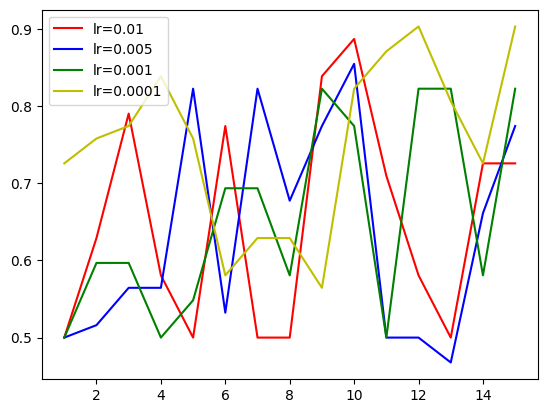

In [ ]:
# Epocas del eje X
VGG16_001_val_acc = VGG16_001_val_acc1 + VGG16_001_val_acc2
VGG16_0005_val_acc = VGG16_0005_val_acc1 + VGG16_0005_val_acc2
VGG16_0001_val_acc = VGG16_0001_val_acc1 + VGG16_0001_val_acc2
VGG16_00001_val_acc = VGG16_00001_val_acc1 + VGG16_00001_val_acc2
epochs = range(1, len(VGG16_001_val_acc) + 1)

# Representamos las gráficas
plt.plot(epochs, VGG16_001_val_acc, 'r', label='lr=0.01')
plt.plot(epochs, VGG16_0005_val_acc, 'b', label='lr=0.005')
plt.plot(epochs, VGG16_0001_val_acc, 'g', label='lr=0.001')
plt.plot(epochs, VGG16_00001_val_acc, 'y', label='lr=0.0001')

# Incluir leyenda
plt.legend(loc='best')

# Mostrar la figura
plt.show()